In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import seaborn as sns
import json

TODOS:
- generalizirati labele motion i people?
- EDA na outdoor_sensor_provider i dodavanje kao feature-a
- također dodati i traffic_data
- napraviti labele
- plottati label 0 (kada nije nista od ovoga istina) i provjeriti varijancu, ne bih trebala biti velika

- Motion.csv: Funkcionira li labelanje 0 i 1 na isti nacin kao otvaranje vrata, npr ako je 15:00:10 1, te u 15:00:40 0, onda je tih 30 sekundi detektiran pokret? 
Pretpostavljam da je senzor postavljen unutar sobe da mainly prati prisutnost ljudi? Ako je tako, onda sljedeće pitanje, situacija u datasetu Motion.csv:
15/10/2024 08:09	1
15/10/2024 08:10	0
15/10/2024 08:10	1
15/10/2024 08:15	0
15/10/2024 08:15	1
15/10/2024 08:16	0
15/10/2024 08:16	1
15/10/2024 08:19	0
15/10/2024 08:19	1
15/10/2024 08:20	0
15/10/2024 08:20	1
15/10/2024 08:22	0
15/10/2024 08:23	1
15/10/2024 08:24	0
15/10/2024 08:24	1
15/10/2024 08:25	0
15/10/2024 08:25	1
15/10/2024 08:27	0
15/10/2024 08:27	1
15/10/2024 08:28	0
15/10/2024 08:28	1
15/10/2024 08:33	0
15/10/2024 08:33	1
15/10/2024 08:34	0
15/10/2024 08:36	1
15/10/2024 08:38	0
Ako je svrha senzora detekcija ljudi u sobi pretpostavljam da bi bilo najbolje zaključiti da je netko bio u sobi 08:09 - 08:38 i na taj način napraviti jedan kontinuirani label od pola sata? 
Ako pogledamo People.csv, u ovom vremenskom intervalu detektirana je osoba na sljedeći način:
15/10/2024 08:24	1
15/10/2024 08:25	0
15/10/2024 08:26	0
15/10/2024 08:27	0
15/10/2024 08:28	1
15/10/2024 08:29	0
15/10/2024 08:30	0
15/10/2024 08:31	1
15/10/2024 08:33	0
15/10/2024 08:34	0
15/10/2024 08:35	1
15/10/2024 08:36	0
Kada usporedimo ova dva intervala, dolazimo do zaključka da nije pametno zaključiti da je čovjek u sobi tih pola sata bazirano na motion.csv, kakav bi to onda mogao biti movement, mislim da nije prašina etc. zato što je previše consistently detectano, ili?


- Outdoor_sensor_provider_2 
Senzor za zrak vani, time delta 5 min, na koji nacin najbolje aproksimirati data između? Moja ideja linearnom funkcijom (lin. rast/pad)

- People.csv 
Detekcija broja ljudi u sobi (int). Kolko ja vidim senzor ne funkcionira na način da detecta promijene nego vrsi ocitanja svaku minutu, kako da onda fillam data između?

- Traffic_data, kako je ovo detectano, gdje je pozicionirano? Trebam bolje biti upoznat o detaljima da mogu doći sam do zaključka. Data tek od 22.10, jel ima smisla dodavati taj label ako nismo u vremenu prije, hoce li model doci do krivoh zakljucka?

## Data preprocessing

### Original dataset with garden_door and hallway_door

In [143]:
# Load and preprocess door and window data
garden_door_df = pd.read_csv('datasets/Door_windows.csv')
garden_door_df = garden_door_df.drop('Door_balcony_1st_floor', axis=1)
garden_door_df = garden_door_df.drop('Door_Hallway', axis=1)
garden_door_df['Date'] = pd.to_datetime(garden_door_df['Date'], format='%d/%m/%Y %H:%M')
garden_door_df['Door_Garden'] = garden_door_df['Door_Garden'].map({'on': 1, 'off': 0})
garden_door_df = garden_door_df.drop_duplicates(subset='Date', keep='last')

# RESAMPLANJE U 1 SEKUNDU
garden_door_df.set_index('Date', inplace=True)
garden_door_df = garden_door_df.resample('1s').ffill()
garden_door_df.reset_index(inplace=True)
garden_door_df = garden_door_df.drop('Unnamed: 0', axis=1)
#garden_door_df.to_csv("datasets/garden_door_dataset.csv", index=False)

# Load and preprocess door and window data
hallway_door_df = pd.read_csv('datasets/Door_windows.csv')
hallway_door_df = hallway_door_df.drop('Door_balcony_1st_floor', axis=1)
hallway_door_df = hallway_door_df.drop('Door_Garden', axis=1)
hallway_door_df['Date'] = pd.to_datetime(hallway_door_df['Date'], format='%d/%m/%Y %H:%M')
hallway_door_df['Door_Hallway'] = hallway_door_df['Door_Hallway'].map({'on': 1, 'off': 0})
hallway_door_df = hallway_door_df.drop_duplicates(subset='Date', keep='last')

# RESAMPLANJE U 1 SEKUNDU
hallway_door_df.set_index('Date', inplace=True)
hallway_door_df = hallway_door_df.resample('1s').ffill()
hallway_door_df.reset_index(inplace=True)
hallway_door_df = hallway_door_df.drop('Unnamed: 0', axis=1)
#garden_door_df.to_csv("datasets/garden_door_dataset.csv", index=False)

sensor_df = pd.read_csv('datasets/LS0623020168.csv')
# Convert UTC to UTC+2
sensor_df['timestamp(ZG)'] = pd.to_datetime(sensor_df['timestamp(UTC)']) + timedelta(hours=2)

# Handling daylight savings ZG: (UTC+2) -> (UTC+1)
dst_cutoff = pd.Timestamp('2024-10-27 03:00:00')
sensor_df['timestamp(ZG)'] = sensor_df['timestamp(ZG)'].apply(
    lambda x: x - timedelta(hours=1) if x >= dst_cutoff else x
)

merged_df = pd.merge(sensor_df, garden_door_df[["Date", "Door_Garden"]],
                     left_on="timestamp(ZG)", right_on="Date", how="left")
merged_df = pd.merge(merged_df, hallway_door_df[["Date", "Door_Hallway"]],
                     left_on="timestamp(ZG)", right_on="Date", how="left")
merged_df = merged_df.drop(columns=["Date_x", "Date_y"])
merged_df = merged_df[merged_df["timestamp(ZG)"] >= garden_door_df['Date'].min()]

# Dropping duplicated values of timestamp resulted in moving the clock by 1 hour
merged_df = merged_df.drop_duplicates(subset='timestamp(ZG)', keep='first')
merged_df = merged_df.dropna()

#merged_df.to_csv("datasets/merged_sensor_data.csv", index=False)

### Motion dataset

In [144]:
motion_df = pd.read_csv('datasets/Motion.csv')
motion_df = motion_df.drop('Unnamed: 0', axis=1)
motion_df['Timestamp'] = pd.to_datetime(motion_df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
motion_df = motion_df.set_index('Timestamp').resample('1s').ffill().reset_index()
# Merge motion detection data with primary dataset based on timestamps
merged_df = pd.merge_asof(
    merged_df.rename(columns={'timestamp(ZG)': 'timestamp'}).sort_values('timestamp'), 
    motion_df.rename(columns={'Timestamp': 'timestamp'}).sort_values('timestamp'), 
    on='timestamp',
    direction='backward'
).rename(columns={'timestamp': 'timestamp(ZG)'})
#merged_df.to_csv("datasets/merged_sensor_data_with_motion.csv", index=False)

### People dataset

In [145]:
people_df = pd.read_csv('datasets/People.csv')
people_df = people_df.drop('Unnamed: 0', axis=1)
people_df.rename(columns={'People in a room' : 'people_in_room'}, inplace= True)
people_df['Timestamp'] = pd.to_datetime(people_df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
people_df = people_df.set_index('Timestamp').resample('1s').ffill().reset_index()
merged_df = pd.merge_asof(
    merged_df.rename(columns={'timestamp(ZG)': 'timestamp'}).sort_values('timestamp'), 
    people_df.rename(columns={'Timestamp': 'timestamp'}).sort_values('timestamp'), 
    on='timestamp',
    direction='backward'
).rename(columns={'timestamp': 'timestamp(ZG)'})

In [146]:
# Fill missing values in 'motion_detection' based on 'people_in_room'
merged_df['Motion_detection'] = merged_df['Motion_detection'].fillna(
    merged_df['people_in_room'].apply(lambda x: 0 if x == 0 else 1)
)

### Outdoor sensor dataset

In [147]:
outdoor_sensor_df = pd.read_csv('datasets\Outdoor_sensor_provider_2.csv')
outdoor_sensor_df = outdoor_sensor_df.drop('Unnamed: 0', axis=1)
outdoor_sensor_df['Timestamp'] = pd.to_datetime(outdoor_sensor_df['Timestamp'], format='%Y-%m-%d %H:%M:%S')
outdoor_sensor_df = outdoor_sensor_df.dropna()
# Removing duplicates due to rollback of clock, keeping the first, the same as in the indoor sensor data, so they match
outdoor_sensor_df = outdoor_sensor_df.drop_duplicates(subset='Timestamp', keep='first')
# Resampling the data to 1 second intervals, using linear approximation to fill missing values
outdoor_sensor_df = outdoor_sensor_df.set_index('Timestamp').resample('1s').interpolate(method='linear').reset_index()
outdoor_sensor_df = outdoor_sensor_df.rename(columns=lambda x: "outdoor_" + x)
merged_df = pd.merge_asof(
    merged_df.rename(columns={'timestamp(ZG)': 'timestamp'}).sort_values('timestamp'), 
    outdoor_sensor_df.rename(columns={'outdoor_Timestamp': 'timestamp'}).sort_values('timestamp'), 
    on='timestamp',
    direction='backward'
).rename(columns={'timestamp': 'timestamp(ZG)'})


In [148]:
merged_df.columns

Index(['timestamp(UTC)', 'NetCO2-CO2(ppm)', 'NetCO2-CO2_ug', 'NetADC_O3-O3_ug',
       'NetADC_O3-O3(ppb)', 'NetADC_CO-CO_ug', 'NetADC_CO-CO( ppb)',
       'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB(ppm)',
       'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 'NetBME280-TEMP_EXT(°C)',
       'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2(ppb)',
       'timestamp(ZG)', 'Door_Garden', 'Door_Hallway', 'Motion_detection',
       'people_in_room', 'outdoor_NO2(µg/m³)', 'outdoor_NO(µg/m³)',
       'outdoor_O3(µg/m³)', 'outdoor_CO2(mg/m³)', 'outdoor_CO(mg/m³)',
       'outdoor_H2S(µg/m³)', 'outdoor_PM1(µg/m³)', 'outdoor_PM2P5(µg/m³)',
       'outdoor_PM10(µg/m³)', 'outdoor_VOC(mg/m³)', 'outdoor_temperature(C)',
       'outdoor_relativeHumidity(%)', 'outdoor_pressure(µg/m³)',
       'outdoor_windDirection(degrees)', 'outdoor_windSpeed(m/s)',
       'outdoor_gust(m/s)'],
      dtype='object')

### Adding experiment column 

In [149]:
with open("datasets/experiments.json", "r") as file:
    experiment_data = json.load(file)

start_time = merged_df['timestamp(ZG)'].min()
end_time = merged_df['timestamp(ZG)'].max()

all_timestamps = pd.date_range(start=start_time, end=end_time, freq="1s")
experiment_df = pd.DataFrame({"Timestamp": all_timestamps, "experiment": 0})

for ranges in experiment_data["experiments"].values():
    for start, end in ranges:
        start, end = pd.to_datetime(start), pd.to_datetime(end)
        experiment_df.loc[(experiment_df['Timestamp'] >= start) & (experiment_df['Timestamp'] <= end), 'experiment'] = 1

merged_df = pd.merge_asof(
    merged_df.rename(columns={'timestamp(ZG)': 'timestamp'}).sort_values('timestamp'), 
    experiment_df.rename(columns={'Timestamp': 'timestamp'}).sort_values('timestamp'), 
    on='timestamp',
    direction='backward'
).rename(columns={'timestamp': 'timestamp(ZG)'})

#merged_df.to_csv("datasets/merged_sensor_data_with_motion_experiments.csv", index=False)

### Filtering out times of experiments being done (except door_opened)

In [150]:
"""with open("datasets/experiments.json", "r") as file:
    experiment_data = json.load(file)

# Convert the experiment intervals into a DataFrame
intervals = []
for experiment, times in experiment_data["experiments"].items():
    for time_range in times:
        intervals.append({"start": pd.to_datetime(time_range[0]), "end": pd.to_datetime(time_range[1])})
intervals = intervals[1:]   # OSTAVLJAMO DOOR OPENING
intervals_df = pd.DataFrame(intervals)

# Filter out rows within the intervals
for _, row in intervals_df.iterrows():
    merged_df = merged_df[
        ~((merged_df['timestamp(ZG)'] >= row['start']) & (merged_df['timestamp(ZG)'] <= row['end']))
    ]
    
merged_df = merged_df.dropna()
#merged_df.to_csv("datasets/merged_sensor_data_no_experiments.csv", index=False)"""

'with open("datasets/experiments.json", "r") as file:\n    experiment_data = json.load(file)\n\n# Convert the experiment intervals into a DataFrame\nintervals = []\nfor experiment, times in experiment_data["experiments"].items():\n    for time_range in times:\n        intervals.append({"start": pd.to_datetime(time_range[0]), "end": pd.to_datetime(time_range[1])})\nintervals = intervals[1:]   # OSTAVLJAMO DOOR OPENING\nintervals_df = pd.DataFrame(intervals)\n\n# Filter out rows within the intervals\nfor _, row in intervals_df.iterrows():\n    merged_df = merged_df[\n        ~((merged_df[\'timestamp(ZG)\'] >= row[\'start\']) & (merged_df[\'timestamp(ZG)\'] <= row[\'end\']))\n    ]\n    \nmerged_df = merged_df.dropna()\n#merged_df.to_csv("datasets/merged_sensor_data_no_experiments.csv", index=False)'

### Filtering out (removing) when hallway doors are opened by themselves

In [151]:
"""merged_df = merged_df[~((merged_df['Door_Hallway'] == 1) & (merged_df['Door_Garden'] == 0))]"""

"merged_df = merged_df[~((merged_df['Door_Hallway'] == 1) & (merged_df['Door_Garden'] == 0))]"

## LET'S TRY REMOVING ALL THE LABELED DATA, UNLESS THE DOOR IS OPENED AT THAT TIME

In [152]:
# Calculate the original number of rows
original_row_count = merged_df.shape[0]
door_garden_count = (merged_df['Door_Garden'] == 1).sum()

# Define the columns to check
columns_to_check = ['Door_Hallway', 'Motion_detection', 'people_in_room', 'experiment']

# Apply the filtering condition
merged_df = merged_df[
    ~((merged_df[columns_to_check].any(axis=1)) & (merged_df['Door_Garden'] == 0))
]

# Calculate the number of rows remaining after filtering
remaining_row_count = merged_df.shape[0]

# Calculate the number of rows deleted
rows_deleted = original_row_count - remaining_row_count

# Calculate the percentage of rows deleted
percentage_deleted = (rows_deleted / original_row_count) * 100

door_garden_count2 = (merged_df['Door_Garden'] == 1).sum()

# Print the results
print(f"Original number of rows: {original_row_count}")
print(f"Number of rows deleted: {rows_deleted}")
print(f"Percentage of rows deleted: {percentage_deleted:.2f}%")
#print(f"Before number of door_garden rows: {door_garden_count}, after number of door_garden rows: {door_garden_count2}")


Original number of rows: 313916
Number of rows deleted: 15502
Percentage of rows deleted: 4.94%


## Visualizing the data

In [153]:
# Visualizing the whole dataset
"""
# Set up a figure for the subplots
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
fig.suptitle('Time series of paramaters', fontsize=16)

# List of parameters and titles
parameters = [
    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')
]

# Plot each parameter in a separate subplot
for i, (param, title) in enumerate(parameters):
    row, col = divmod(i, 2)
    axs[row, col].plot(sensor_df['timestamp(ZG)'], sensor_df[param])
    axs[row, col].set_title(title)
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel(title)
    axs[row, col].tick_params(axis='x', rotation=45)

axs[7,1].plot(merged_df['timestamp(ZG)'],merged_df['any_door_open'])
axs[7,1].set_title('Any door open')
axs[7,1].set_xlabel('Time')
axs[7,1].set_ylabel('Yes (1), No (0)')
axs[7,1].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
plt.show()
"""

"\n# Set up a figure for the subplots\nfig, axs = plt.subplots(8, 2, figsize=(15, 30))\nfig.suptitle('Time series of paramaters', fontsize=16)\n\n# List of parameters and titles\nparameters = [\n    ('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),\n    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),\n    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),\n    ('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),\n    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),\n    ('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),\n    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),\n    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),\n    ('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),\n    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),\n    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),\n    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),\n    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),\n    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),\n    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)')\n]\n\n# Plot each parameter in a separate s

For visualizing door opening, the data is reduced from 5s to 1m readings, the sensor data is the average value in that 1 minute, each day is saved as image in daily_plots

In [154]:
"""# Generating images by days
import os

parameters = [
    #('NetCO2-CO2(ppm)', 'NetCO2-CO2 (ppm)'),
    ('NetCO2-CO2_ug', 'NetCO2-CO2 (µg)'),
    ('NetADC_O3-O3_ug', 'NetADC_O3-O3 (µg)'),
    #('NetADC_O3-O3(ppb)', 'NetADC_O3-O3 (ppb)'),
    ('NetADC_CO-CO_ug', 'NetADC_CO-CO (µg)'),
    #('NetADC_CO-CO( ppb)', 'NetADC_CO-CO (ppb)'),
    ('NetPM-PM10(µg/m3)', 'NetPM-PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'NetPM-PM25 (µg/m³)'),
    #('NetPid_P1-PPB(ppm)', 'NetPid_P1-PPB (ppm)'),
    ('NetPid_P1-PPB_ug', 'NetPid_P1-PPB (µg)'),
    ('NetBME280-PERC(%)', 'NetBME280 Humidity (%)'),
    ('NetBME280-TEMP_EXT(°C)', 'NetBME280 Temperature (°C)'),
    ('NetBME280-HPA(hPa)', 'NetBME280 Pressure (hPa)'),
    ('NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2 (µg)'),
    ('NetADC_NO2-NO2(ppb)', 'NetADC_NO2-NO2 (ppb)'),
    ('Door_Hallway', 'Door_Hallway'),
    ('Motion_detection', 'Motion_detection'),
    ('people_in_room', 'people_in_room')
]

merged_df = merged_df.drop('timestamp(UTC)', axis=1)

# Set the UTC+1 timestamp as the index
merged_df.set_index('timestamp(ZG)', inplace=True)

# Resample the data to 1-minute intervals and calculate the mean
data_resampled = merged_df.resample('1min').mean()

# Reset the index to make 'timestamp(ZG)' a column again
data_resampled = data_resampled.reset_index()

# Ensure the directory for saving plots exists
output_dir = "daily_plots3"
os.makedirs(output_dir, exist_ok=True)

# Loop through each unique day in the dataset
data_resampled['date'] = data_resampled['timestamp(ZG)'].dt.date
unique_days = data_resampled['date'].unique()

for day in unique_days:
    # Filter data for the specific day
    day_data = data_resampled[data_resampled['date'] == day]
    open_door_times = day_data[day_data['Door_Garden'] == 1]['timestamp(ZG)']
    experiment_times = day_data[day_data['experiment'] == 1]['timestamp(ZG)']
    
    # Set up a figure for the subplots
    fig, axs = plt.subplots(8, 2, figsize=(15, 22))
    fig.suptitle(
        f'Time series of parameters for {day}, red line = garden door open, grey = experiments being done', 
        fontsize=16
    )
    
    # Plot each parameter in a separate subplot
    for i, (param, title) in enumerate(parameters):
        row, col = divmod(i, 2)
        axs[row, col].plot(day_data['timestamp(ZG)'], day_data[param])
        axs[row, col].set_title(title)
        axs[row, col].set_xlabel('Time')
        axs[row, col].set_ylabel(title)
        axs[row, col].tick_params(axis='x', rotation=45)
        
        # Add vertical lines for door open times with color
        for open_time in open_door_times:
            open_time_door_data = day_data[day_data['timestamp(ZG)'] == open_time]
            if (open_time_door_data['Door_Garden'].values == 1):
                axs[row, col].axvline(x=open_time, color='red', lw=1, alpha=0.2)
        
        for experiment_time in experiment_times:
            experiment_times_data = day_data[day_data['timestamp(ZG)'] == experiment_time]
            if (experiment_times_data['experiment'].values == 1):
                axs[row, col].axvline(x=experiment_time, color='black', lw=1, alpha=0.05)
    
    # Remove unused subplots if they exist
    for j in range(len(parameters), len(axs.flatten())):
        fig.delaxes(axs.flatten()[j])
    
    # Adjust layout and save the plot
    plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit title
    plt.savefig(os.path.join(output_dir, f'{day}.png'))
    plt.close(fig)"""

'# Generating images by days\nimport os\n\nparameters = [\n    #(\'NetCO2-CO2(ppm)\', \'NetCO2-CO2 (ppm)\'),\n    (\'NetCO2-CO2_ug\', \'NetCO2-CO2 (µg)\'),\n    (\'NetADC_O3-O3_ug\', \'NetADC_O3-O3 (µg)\'),\n    #(\'NetADC_O3-O3(ppb)\', \'NetADC_O3-O3 (ppb)\'),\n    (\'NetADC_CO-CO_ug\', \'NetADC_CO-CO (µg)\'),\n    #(\'NetADC_CO-CO( ppb)\', \'NetADC_CO-CO (ppb)\'),\n    (\'NetPM-PM10(µg/m3)\', \'NetPM-PM10 (µg/m³)\'),\n    (\'NetPM-PM25(µg/m3)\', \'NetPM-PM25 (µg/m³)\'),\n    #(\'NetPid_P1-PPB(ppm)\', \'NetPid_P1-PPB (ppm)\'),\n    (\'NetPid_P1-PPB_ug\', \'NetPid_P1-PPB (µg)\'),\n    (\'NetBME280-PERC(%)\', \'NetBME280 Humidity (%)\'),\n    (\'NetBME280-TEMP_EXT(°C)\', \'NetBME280 Temperature (°C)\'),\n    (\'NetBME280-HPA(hPa)\', \'NetBME280 Pressure (hPa)\'),\n    (\'NetADC_NO2-NO2_ug\', \'NetADC_NO2-NO2 (µg)\'),\n    (\'NetADC_NO2-NO2(ppb)\', \'NetADC_NO2-NO2 (ppb)\'),\n    (\'Door_Hallway\', \'Door_Hallway\'),\n    (\'Motion_detection\', \'Motion_detection\'),\n    (\'people_in_ro

In [155]:
"""import os
import math
import pandas as pd
import matplotlib.pyplot as plt

# dropping as it's not a numeric column
merged_df = merged_df.drop('timestamp(UTC)', axis=1)

# -------------------------
# 2. Resample Data to 1-Minute Averages
# -------------------------
# Set 'timestamp(ZG)' as the index, resample to 1-minute frequency, and then reset the index.
merged_df.set_index('timestamp(ZG)', inplace=True)
df_resampled = merged_df.resample('1min').mean().reset_index()

# Create a new column holding just the date (for grouping later)
df_resampled['date'] = df_resampled['timestamp(ZG)'].dt.date

# -------------------------
# 3. Define Indoor/Outdoor Parameter Pairs
# -------------------------
# Each tuple contains:
#   (indoor column name, outdoor column name, common label for the parameter)
parameter_pairs = [
    ('NetBME280-TEMP_EXT(°C)', 'outdoor_temperature(C)', 'Temperature (°C)'),
    ('NetBME280-PERC(%)', 'outdoor_relativeHumidity(%)', 'Humidity (%)'),
    ('NetBME280-HPA(hPa)', 'outdoor_pressure(µg/m³)', 'Pressure'),
    ('NetADC_O3-O3_ug', 'outdoor_O3(µg/m³)', 'O₃ (µg/m³)'),
    ('NetADC_CO-CO_ug', 'outdoor_CO(mg/m³)', 'CO'),
    ('NetADC_NO2-NO2_ug', 'outdoor_NO2(µg/m³)', 'NO₂ (µg/m³)'),
    ('NetCO2-CO2_ug', 'outdoor_CO2(mg/m³)', 'CO₂'),
    ('NetPM-PM10(µg/m3)', 'outdoor_PM10(µg/m³)', 'PM10 (µg/m³)'),
    ('NetPM-PM25(µg/m3)', 'outdoor_PM2P5(µg/m³)', 'PM2.5 (µg/m³)')
]

# -------------------------
# 4. Create Output Folder for Daily Plots
# -------------------------
output_dir = "daily_indoor_outdoor_plots"
os.makedirs(output_dir, exist_ok=True)

# -------------------------
# 5. Loop Through Each Day and Plot
# -------------------------
# Get the list of unique days
unique_days = df_resampled['date'].unique()

for day in unique_days:
    # Subset data for the current day
    day_data = df_resampled[df_resampled['date'] == day]
    
    # If you wish to mark events like door openings, extract the times.
    # (This example uses 'Door_Garden' if it exists.)
    door_open_times = []
    if 'Door_Garden' in day_data.columns:
        door_open_times = day_data[day_data['Door_Garden'] == 1]['timestamp(ZG)']
    
    # (If you have an 'experiment' column, you can extract those times similarly.)
    experiment_times = []
    if 'experiment' in day_data.columns:
        experiment_times = day_data[day_data['experiment'] == 1]['timestamp(ZG)']
    
    # Determine the grid size for subplots.
    n_pairs = len(parameter_pairs)
    ncols = 3  # e.g. three columns of subplots
    nrows = math.ceil(n_pairs / ncols)
    
    fig, axs = plt.subplots(nrows, ncols, figsize=(5 * ncols, 4 * nrows), sharex=True)
    axs = axs.flatten()  # Flatten to simplify iteration
    
    # Loop over each indoor/outdoor parameter pair and plot on the same axis.
    for i, (indoor_col, outdoor_col, label) in enumerate(parameter_pairs):
        ax = axs[i]
        # Plot indoor parameter in blue
        ax.plot(day_data['timestamp(ZG)'], day_data[indoor_col], label=f'Indoor {label}', color='blue')
        # Plot outdoor parameter in green
        ax.plot(day_data['timestamp(ZG)'], day_data[outdoor_col], label=f'Outdoor {label}', color='green')
        ax.set_title(label)
        ax.set_xlabel('Time')
        ax.set_ylabel(label)
        ax.tick_params(axis='x', rotation=45)
        
        # Optionally add vertical lines where the door was opened.
        for open_time in door_open_times:
            ax.axvline(x=open_time, color='red', lw=1, alpha=0.2)
        
        # Optionally add vertical lines for experiment times.
        for exp_time in experiment_times:
            ax.axvline(x=exp_time, color='black', lw=1, alpha=0.05)
        
        ax.legend()
    
    # Remove any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    
    # Add a super-title and adjust layout.
    fig.suptitle(f'Indoor vs. Outdoor Air Parameters for {day}', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    # Save the figure for the current day
    output_path = os.path.join(output_dir, f'{day}.png')
    plt.savefig(output_path)
    plt.close(fig)
"""

'import os\nimport math\nimport pandas as pd\nimport matplotlib.pyplot as plt\n\n# dropping as it\'s not a numeric column\nmerged_df = merged_df.drop(\'timestamp(UTC)\', axis=1)\n\n# -------------------------\n# 2. Resample Data to 1-Minute Averages\n# -------------------------\n# Set \'timestamp(ZG)\' as the index, resample to 1-minute frequency, and then reset the index.\nmerged_df.set_index(\'timestamp(ZG)\', inplace=True)\ndf_resampled = merged_df.resample(\'1min\').mean().reset_index()\n\n# Create a new column holding just the date (for grouping later)\ndf_resampled[\'date\'] = df_resampled[\'timestamp(ZG)\'].dt.date\n\n# -------------------------\n# 3. Define Indoor/Outdoor Parameter Pairs\n# -------------------------\n# Each tuple contains:\n#   (indoor column name, outdoor column name, common label for the parameter)\nparameter_pairs = [\n    (\'NetBME280-TEMP_EXT(°C)\', \'outdoor_temperature(C)\', \'Temperature (°C)\'),\n    (\'NetBME280-PERC(%)\', \'outdoor_relativeHumidity(%

## Data normalization

In [156]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# parameters_to_normalize = [
#     'NetCO2-CO2(ppm)', 'NetCO2-CO2_ug', 'NetADC_O3-O3_ug',
#     'NetADC_O3-O3(ppb)', 'NetADC_CO-CO_ug', 'NetADC_CO-CO( ppb)',
#     'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB(ppm)',
#     'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 'NetBME280-TEMP_EXT(°C)',
#     'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2(ppb)'
# ]

parameters_to_normalize = [
    'NetCO2-CO2(ppm)', 'NetCO2-CO2_ug', 'NetADC_O3-O3_ug',
    'NetADC_O3-O3(ppb)', 'NetADC_CO-CO_ug', 'NetADC_CO-CO( ppb)',
    'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB(ppm)',
    'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 'NetBME280-TEMP_EXT(°C)',
    'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug', 'NetADC_NO2-NO2(ppb)',
    'outdoor_NO2(µg/m³)', 'outdoor_NO(µg/m³)',
    'outdoor_O3(µg/m³)', 'outdoor_CO2(mg/m³)', 'outdoor_CO(mg/m³)',
    'outdoor_H2S(µg/m³)', 'outdoor_PM1(µg/m³)', 'outdoor_PM2P5(µg/m³)',
    'outdoor_PM10(µg/m³)', 'outdoor_VOC(mg/m³)', 'outdoor_temperature(C)',
    'outdoor_relativeHumidity(%)', 'outdoor_pressure(µg/m³)',
    'outdoor_windDirection(degrees)', 'outdoor_windSpeed(m/s)',
    'outdoor_gust(m/s)'
]

#scaler = MinMaxScaler()  # Use StandardScaler() for Z-score normalization
scaler = StandardScaler()
sensor_df_normalized = merged_df.copy()
sensor_df_normalized[parameters_to_normalize] = scaler.fit_transform(merged_df[parameters_to_normalize])

In [157]:
"""data_to_plot = sensor_df_normalized[parameters_to_normalize]

plt.figure(figsize=(15, 8))  # Set the figure size
sns.boxplot(data=data_to_plot, orient='v', palette='coolwarm')

plt.title('Distribucija normaliziranih parametara senzora', fontsize=16)  # Plot title in Croatian
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.xlabel('Parametri senzora', fontsize=12)
plt.ylabel('Vrijednosti (normalizirane)', fontsize=12)

plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()"""

"data_to_plot = sensor_df_normalized[parameters_to_normalize]\n\nplt.figure(figsize=(15, 8))  # Set the figure size\nsns.boxplot(data=data_to_plot, orient='v', palette='coolwarm')\n\nplt.title('Distribucija normaliziranih parametara senzora', fontsize=16)  # Plot title in Croatian\nplt.xticks(rotation=90)  # Rotate x-axis labels for better readability\nplt.xlabel('Parametri senzora', fontsize=12)\nplt.ylabel('Vrijednosti (normalizirane)', fontsize=12)\n\nplt.tight_layout()  # Adjust layout to prevent overlap\nplt.show()"

Correlation matrix with normalized data is the same as the corr. matrix with un-normalized data

## PCA Analysis - HALLWAY, MOTION, PEOPLE IN ROOM, EXPERIMENT ADDED

In [158]:
from sklearn.decomposition import PCA

parameters_for_PCA = [
    'NetCO2-CO2_ug', 'NetADC_O3-O3_ug', 'NetADC_CO-CO_ug',
    'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 
    'NetBME280-TEMP_EXT(°C)', 'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug',
    'Door_Hallway', 'Motion_detection','people_in_room', 'experiment'
]

# parameters_for_PCA = [
#     'NetCO2-CO2_ug', 'NetADC_O3-O3_ug', 'NetADC_CO-CO_ug',
#     'NetPM-PM10(µg/m3)', 'NetPM-PM25(µg/m3)', 'NetPid_P1-PPB_ug', 'NetBME280-PERC(%)', 
#     'NetBME280-TEMP_EXT(°C)', 'NetBME280-HPA(hPa)', 'NetADC_NO2-NO2_ug',
#     'Door_Hallway', 'Motion_detection','people_in_room', 'experiment',
#     'outdoor_NO2(µg/m³)', 'outdoor_NO(µg/m³)',
#     'outdoor_O3(µg/m³)', 'outdoor_CO2(mg/m³)', 'outdoor_CO(mg/m³)',
#     'outdoor_H2S(µg/m³)', 'outdoor_PM1(µg/m³)', 'outdoor_PM2P5(µg/m³)',
#     'outdoor_PM10(µg/m³)', 'outdoor_VOC(mg/m³)', 'outdoor_temperature(C)',
#     'outdoor_relativeHumidity(%)', 'outdoor_pressure(µg/m³)',
#     'outdoor_windDirection(degrees)', 'outdoor_windSpeed(m/s)',
#     'outdoor_gust(m/s)'
# ]

pca = PCA(n_components=10)
X_pca = pca.fit_transform(sensor_df_normalized[parameters_for_PCA])

### Scree plot

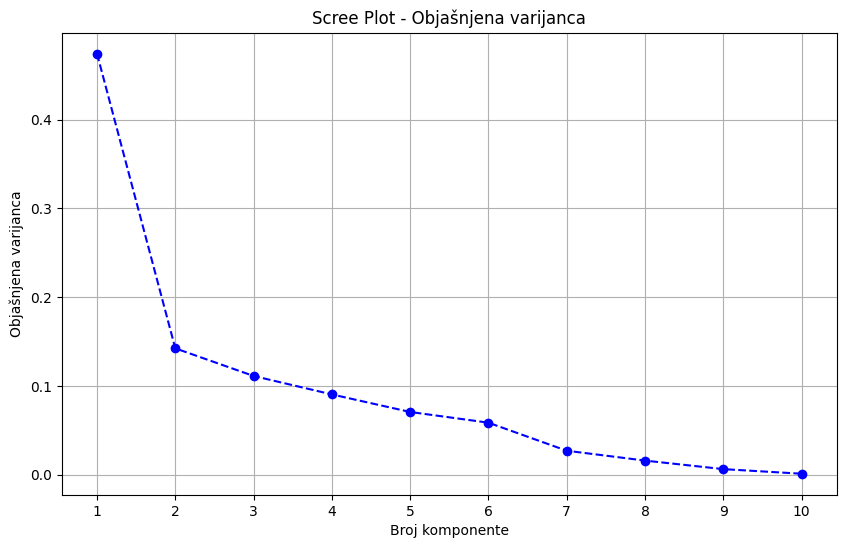

In [159]:
# Visualize explained variance ratio
plt.figure(figsize=(10, 6))
components = np.arange(1, len(pca.explained_variance_ratio_) + 1)  # Component indices
plt.plot(components, pca.explained_variance_ratio_, marker='o', linestyle='--', color='b')
plt.title('Scree Plot - Objašnjena varijanca')
plt.xlabel('Broj komponente')
plt.ylabel('Objašnjena varijanca')
plt.xticks(components)
plt.grid()
plt.show()


### Cumulative Explained Variance

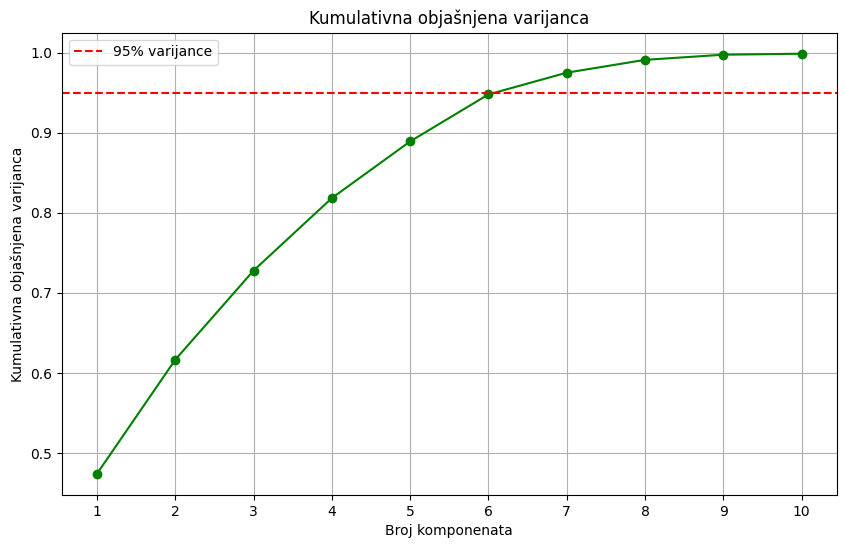

In [160]:
# Cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

plt.figure(figsize=(10, 6))
plt.plot(components, cumulative_variance, marker='o', linestyle='-', color='g')
plt.title('Kumulativna objašnjena varijanca')
plt.xlabel('Broj komponenata')
plt.ylabel('Kumulativna objašnjena varijanca')
plt.xticks(components)
plt.grid()

# Add a threshold line (e.g., 95% variance explained)
plt.axhline(y=0.95, color='r', linestyle='--', label='95% varijance')
plt.legend()
plt.show()


### PCA Loadings (Feature Contribution)

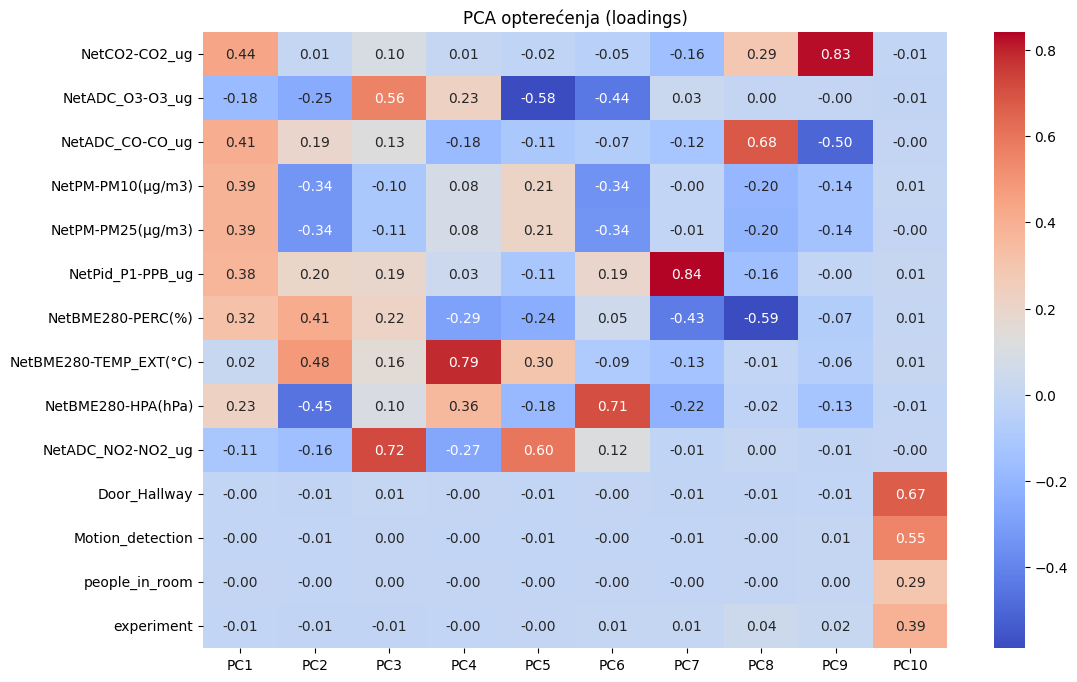

In [161]:
# Extract PCA components (loadings)
loadings = pca.components_.T  # Transpose to align with features
feature_names = parameters_for_PCA  # List of original feature names

# Create a DataFrame for loadings
loadings_df = pd.DataFrame(loadings, columns=[f'PC{i+1}' for i in range(loadings.shape[1])], index=feature_names)

# Plot heatmap for loadings
plt.figure(figsize=(12, 8))
sns.heatmap(loadings_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('PCA opterećenja (loadings)')
plt.show()


# MODELS


In [162]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate_model(y_pred, y_test, name):
    cm = confusion_matrix(y_test, y_pred)
    mcc = matthews_corrcoef(y_test, y_pred)
    print("="*50)
    print(f"Results for {name}:")
    print(f"MCC: {mcc:.4f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"Confusion Matrix for {name}")
    plt.show()
    print("="*50)

## GRU

### GRU v1 - takes unnormalized PCA (better)

In [163]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

#X = sensor_df_normalized[['NetADC_CO-CO_ug']].values
y = merged_df[['Door_Garden']].values
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, shuffle=False)

X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

model = Sequential([
    GRU(16, activation='tanh', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(8, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # For binary classification
])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    verbose=1, 
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)

Epoch 1/30


C:\Users\tjura\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7461/7461 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - accuracy: 0.9689 - loss: 0.1217 - val_accuracy: 0.9960 - val_loss: 0.0308
Epoch 2/30
7461/7461 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9957 - loss: 0.0174 - val_accuracy: 0.9957 - val_loss: 0.0320
Epoch 3/30
7461/7461 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - accuracy: 0.9961 - loss: 0.0149 - val_accuracy: 0.9954 - val_loss: 0.0365
Epoch 4/30
7461/7461 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9960 - loss: 0.0138 - val_accuracy: 0.9955 - val_loss: 0.0387
Epoch 5/30
7461/7461 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9965 - loss: 0.0119 - val_accuracy: 0.9957 - val_loss: 0.0390
Epoch 6/30
7461/7461 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.9964 - loss: 0.0117 - val_accuracy: 0.9955 - val_loss: 0.0415
Test Loss: 0.0308, Test Accuracy: 0.9960
1866/1866 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


Best MCC: 0.9393 at Threshold: 0.1960000000000001
Results for GRU v2:
MCC: 0.9393
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57715
         1.0       1.00      0.89      0.94      1968

    accuracy                           1.00     59683
   macro avg       1.00      0.94      0.97     59683
weighted avg       1.00      1.00      1.00     59683

Confusion Matrix:



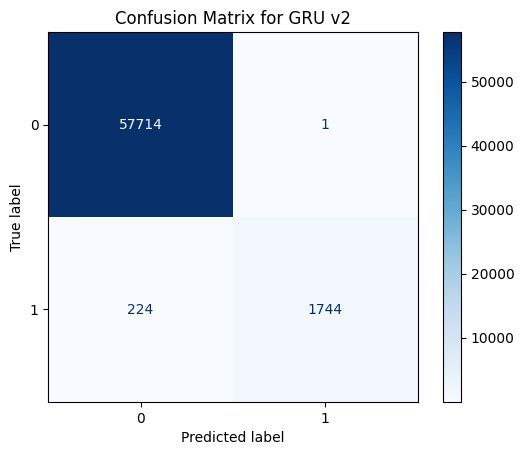

In [165]:
# ORIGINAL (REMOVED HALLWAY_DOOR, EXPERIMENTS, even if garden_door = 1)
# 0.1  = MCC 0.504, experiments removed
# 0.1 = MCC 0.57, experiments, door_hallway removed
# 0.00338 = MCC 0.7784, experiments, door_hallway removed

# ADDED HALLWAY_DOOR, PEOPLE, MOTION, EXPERIMENTS
# 0.02743 = MCC 0.7148

# REMOVED HALLWAY_DOOR, PEOPLE, MOTION, EXPERIMENTS (unless garden_door = 1)
# 0.003422 = MCC 0.8225

# REMOVED HALLWAY_DOOR, PEOPLE, MOTION, EXPERIMENTS (unless garden_door = 1) 
# THIS TIME ACTUALLY INCLUDING THE people, motion, experiments in PCA LOOOL
# 0.018 = MCC 0.9418

# REMOVED HALLWAY_DOOR, ACTUALLY ADDED PEOPLE, MOTION, EXPERIMENTS, OUTDOOR (unless garden_door = 1) 
# 0.480 = MCC 0.7896
 
best_mcc = -1  # MCC ranges from -1 to 1
best_threshold = 0

for threshold in np.arange(0.1, 0.3, 0.001):
    # Binarize the predictions based on the threshold
    y_pred = (y_pred_prob > threshold).astype(int)
    
    mcc = matthews_corrcoef(y_test, y_pred)
    if mcc > best_mcc:
        best_mcc = mcc
        best_threshold = threshold

print(f"Best MCC: {best_mcc:.4f} at Threshold: {best_threshold}")
evaluate_model((y_pred_prob > best_threshold).astype(int), y_test, "GRU v2")